# Private Max Ratio

In [1]:
import numpy as np
import pandas as pd
from sympy import log, solve, symbols

from synthflow.release import (
    optimize_max_ratio_by_faliure,
    optimize_max_ratio_by_pseudo_threshold,
)

## CURRENT APPROCH

In [2]:
optimize_max_ratio_by_pseudo_threshold?

Signature:
optimize_max_ratio_by_pseudo_threshold(
    prob_pass,
    min_synth_count,
    threshold,
    epsilon,
)
Docstring:
We want to reduce the sd of the nosie. The SD (by the GS) is monitically decreasing
as function of the clipping factor (given a fixed epsilon).
Therefore, we could set the clipping factor to the actual threshold,
and then set "pesudo-threshold" which is lower,
and that the probability of the noise + pesudo threshold
to pass the actual threshold is bounded by a probability prob_pass.

So we want to calculate:
param = GS(k) / eps
CDF(threshold - pseudo_threshold, param) = prob_pass
pesudo_threshold = threshold - PPF(prob_pass, param)
File:      ~/.local/lib/python3.8/site-packages/synthflow/release.py
Type:      function


In [3]:
optimize_max_ratio_by_pseudo_threshold(
    prob_pass=0.05, min_synth_count=50, threshold=2, epsilon=0.3
)

(1.4095935658989616, 2, 0.0769230769230771, 0.256410256410257)

In [4]:
# looser threshold if we cannot pass the previous one

optimize_max_ratio_by_pseudo_threshold(
    prob_pass=0.05, min_synth_count=50, threshold=3, epsilon=0.3
)

(1.69664994736186, 3, 0.16981132075471717, 0.5660377358490573)

## OLD APPROACH
Note: still using 100 for `min_synth_count` instead of 50.

Check that we have the correct solution of optimal given epsilon

In [5]:
clipping_factor1, epsilon1, global_sensitivty1 = optimize_max_ratio_by_faliure(
    prob_failure=1 / 20, min_synth_count=100, threshold=2
)

clipping_factor2, epsilon2, global_sensitivty2 = optimize_max_ratio_by_faliure(
    prob_failure=1 / 20, min_synth_count=100, threshold=2, epsilon=epsilon1
)

In [6]:
k, p, s, epsilon, t = symbols("k p s epsilon t", positive=True)
expr = (k - 1 / (1 / k + 1 / s)) * log(1 / (2 * p)) / (k - t) / epsilon - 1
sol1, sol2 = solve(expr, k)

In [7]:
vals = [(p, 1 / 20), (s, 100), (t, 2), (epsilon, epsilon1)]
clipping_factor1, min(
    [sol1.subs(vals), sol2.subs(vals)]
), global_sensitivty1 / epsilon1, epsilon1

(4.081632653061225, 4.08163246880547, 0.9040415745741159, 0.17705383260238752)

In [8]:
clipping_factor3, epsilon3, global_sensitivty3 = optimize_max_ratio_by_faliure(
    prob_failure=1 / 50, min_synth_count=100, threshold=2, epsilon=0.3
)

vals = [(p, 1 / 50), (s, 100), (t, 2), (epsilon, epsilon3)]
clipping_factor3, min([sol1.subs(vals), sol2.subs(vals)]), global_sensitivty3 / epsilon3

(2.84362873934316, 2.84362873934316, 0.2620880037761945)

Understand the impact of epsilon

In [9]:
df = pd.DataFrame(
    [
        dict(
            zip(
                "factor eps sens".split(),
                optimize_max_ratio_by_faliure(
                    prob_failure=1 / 20, min_synth_count=100, threshold=2, epsilon=ep
                ),
            )
        )
        for ep in np.arange(0.2, 1.1, 0.1)
    ]
)

df["param"] = df["sens"] / df["eps"]
df["var"] = 2 * df["param"] ** 2
df["sd"] = np.sqrt(df["var"])

df = df.set_index("eps")

df

,factor,sens,param,var,sd
eps,,,,,
0.2,3.017743,0.088400,0.442000,0.390729,0.625083
0.3,2.449516,0.058567,0.195222,0.076223,0.276086
0.4,2.296870,0.051572,0.128929,0.033245,0.182333
0.5,2.222534,0.048323,0.096645,0.018681,0.136677
0.6,2.178197,0.046434,0.077390,0.011978,0.109446
0.7,2.148670,0.045197,0.064567,0.008338,0.091311
0.8,2.127571,0.044323,0.055403,0.006139,0.078352
0.9,2.111731,0.043672,0.048524,0.004709,0.068624
1.0,2.099399,0.043168,0.043168,0.003727,0.061049


<AxesSubplot:xlabel='eps'>

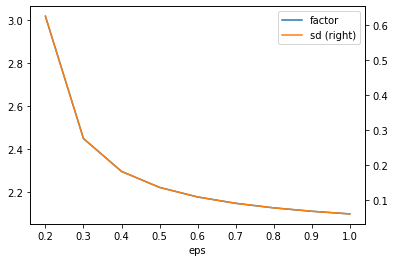

In [10]:
df[["factor", "sd"]].plot(secondary_y="sd")

In [11]:
optimize_max_ratio_by_faliure(
    prob_failure=1 / 20, min_synth_count=100, threshold=2, epsilon=0.3
)

(2.449515885601045, 0.3, 0.05856668059331627)